# Time Series - Wind Power - PE La Castellana

In [2]:
import sys 
print(sys.version)

3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from numpy import log

from dateutil.parser import parse 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (21,7), 'figure.dpi':120})
%matplotlib inline

## meteostat
from datetime import datetime
from shapely.geometry import Point
from meteostat import Hourly

##mis funciones
#from datetime import timedelta #si no se define dentro de la funcion arroja error
from clean_data import remover_valores_repetidos
from clean_data import rango_fechas_repe
from clean_data import rango_fechas_repe_exc
from clean_data import weighted_circular_mean



El dataset que se va a trabajar corresponde al Parque Eólico La Castellana (localizado en Bahia Blanca).

In [4]:
# Custom date parsing function for the "Date" column
def custom_date_parser(date_string):
    #return pd.to_datetime(date_string, format='%d/%m/%Y %H:%M')
    return pd.to_datetime(date_string, format='%Y-%m-%d %H:%M:%S')


#path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/df_clean_ba.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_ba.csv'

data_types = {          
    #'EnergiaTGW': float        
    
    'AerosDisp': float
    ,'VelViento': float
    ,'DirViento': float
    ,'TempAmb': float
    ,'HumedadRel': float
    ,'PresionAtm': float
    ,'EnergiaSMEC': float
    #,'EPronosticoCammesa': float
    #,'ErrorPronostico': float
    ,'wspd_ms': float
    ,'wdir': float
    ,'temp': float
    ,'pres': float 
}


# Read the CSV file with semicolon as delimiter, specifying the custom date parser
df = pd.read_csv(path, dtype=data_types,decimal=',', parse_dates=['FechaHora'], 
                 date_parser=custom_date_parser, delimiter=';', header=0)



### ----------------------------------------------------------------------------------------------------------------------------------- ###

### Regresión lineal multiple para predecir Vel Viento en el Parque LC en función de las variables meteorologicas en Bahia Blanca

In [5]:
# En caso que la prueba sea exitosa lo subo al incio con los import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
#dataset_mrl = df[['VelViento','wspd_ms','wdir','temp','pres','rhum']]

#con menos variables
dataset_mrl = df[['VelViento','wspd_ms','wdir','temp','pres']]


Creo una variable dummy que considere la velocidad wspd_ms y la direccion del viento wdir

In [7]:
dataset_mrl['w_spd_dir'] = dataset_mrl['wspd_ms'] * dataset_mrl['wdir']
dataset_mrl.head(5)

,VelViento,wspd_ms,wdir,temp,pres,w_spd_dir
0,9.51,8.2,189.0,25.7,1010.6,1549.8
1,9.67,8.8,176.0,25.8,1010.9,1548.8
2,9.05,9.3,180.0,25.6,1010.5,1674.0
3,8.48,8.8,166.0,25.1,1011.3,1460.8
4,7.39,8.8,158.0,24.3,1011.5,1390.4


#### Entrenamiento del modelo

In [8]:
# Creamos X e y
features_cols = [x for x in dataset_mrl.columns if x not in ['VelViento','w_spd_dir']]
X = dataset_mrl[features_cols]
y = dataset_mrl['VelViento']


In [9]:
#verifico nulos
X.isnull().sum()

wspd_ms    0
wdir       0
temp       0
pres       0
dtype: int64

In [10]:
X = X.dropna()  # Elimino valores nulos
y = y[X.index]  # Ajusto la variable dependiente

In [11]:
# Verificamos el shape y el tipo de X e y:
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (41105, 4)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (41105,)
Type y: <class 'pandas.core.series.Series'>


In [12]:
X.columns

Index(['wspd_ms', 'wdir', 'temp', 'pres'], dtype='object')

Split entre train y test sets:

In [13]:
rs = 1

X_train, X_test, y_train, y_test = \
         train_test_split(X, y, test_size=0.3, random_state=rs)

In [14]:
model = LinearRegression(fit_intercept=True)
model

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print ('R2 train: {}'.format(r2_score(y_train, y_pred_train).round(4)))
print ('R2 test: {}'.format(r2_score(y_test, y_pred_test).round(4)))

R2 train: 0.3407
R2 test: 0.3512


Veamos si la variabiable dummy captura mejor la relación entre vel y dir del viento y mejora la performance del modelo:

In [15]:
# Creamos X e y
features_cols = [x for x in dataset_mrl.columns if x not in ['VelViento']]
X = dataset_mrl[features_cols]
y = dataset_mrl['VelViento']

In [16]:
# Verificamos el shape y el tipo de X e y:
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (41105, 5)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (41105,)
Type y: <class 'pandas.core.series.Series'>


In [17]:
X.columns

Index(['wspd_ms', 'wdir', 'temp', 'pres', 'w_spd_dir'], dtype='object')

In [18]:
X = X.dropna()  # Elimino valores nulos
y = y[X.index]  # Ajusto la variable dependiente

In [19]:
rs = 1

X_train, X_test, y_train, y_test = \
         train_test_split(X, y, test_size=0.3, random_state=rs)

In [20]:
model = LinearRegression(fit_intercept=True)
model

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print ('R2 train: {}'.format(r2_score(y_train, y_pred_train).round(4)))
print ('R2 test: {}'.format(r2_score(y_test, y_pred_test).round(4)))

R2 train: 0.3666
R2 test: 0.3747


Con la variable dummy w_spd_dir no mejora demasiado la capacidad de prediccion del modelo

Reviso los coeficientes del modelo

In [21]:

coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.30118424 -0.0056076  -0.08049266 -0.08387457  0.00190248]
Intercept: 91.51452843121791


In [22]:
dataset_mrl = dataset_mrl.dropna()

In [23]:
dataset_mrl['Vel_Viento_pred'] = model.predict(X)

In [24]:
df['Vel_Viento_pred']= model.predict(X)

In [25]:
df.head(5)

,FechaHora,EnergiaSMEC,AerosDisp,VelViento,TempAmb,DirViento,PresionAtm,wspd_ms,wdir,temp,pres,rhum,Vel_Viento_pred
0,2019-01-30 13:00:00,72.84,17.50,9.51,18.552593,199.99,1003.828148,8.2,189.0,25.7,1010.6,40.0,9.040559
1,2019-01-30 14:00:00,63.27,27.83,9.67,18.116458,197.27,1002.761146,8.8,176.0,25.8,1010.9,40.0,9.259054
2,2019-01-30 15:00:00,64.52,28.67,9.05,17.226304,194.93,1003.884348,9.3,180.0,25.6,1010.5,54.0,9.675055
3,2019-01-30 16:00:00,55.24,30.33,8.48,17.341089,183.57,1003.813168,8.8,166.0,25.1,1011.3,40.0,9.170507
4,2019-01-30 17:00:00,39.72,31.83,7.39,18.480316,166.49,1003.554000,8.8,158.0,24.3,1011.5,40.0,9.129053


<Axes: >

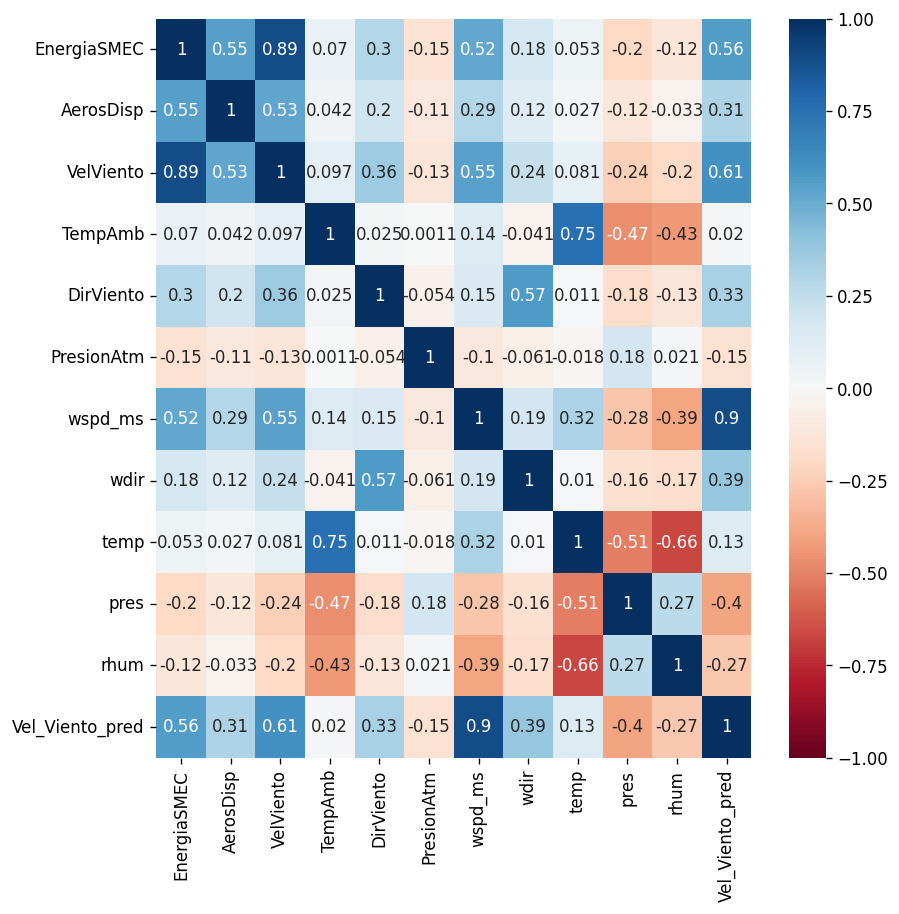

In [26]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','TempAmb','DirViento','PresionAtm','wspd_ms','wdir','temp','pres','rhum','Vel_Viento_pred']

plt.figure(figsize=(8,8))
sns.heatmap(df[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

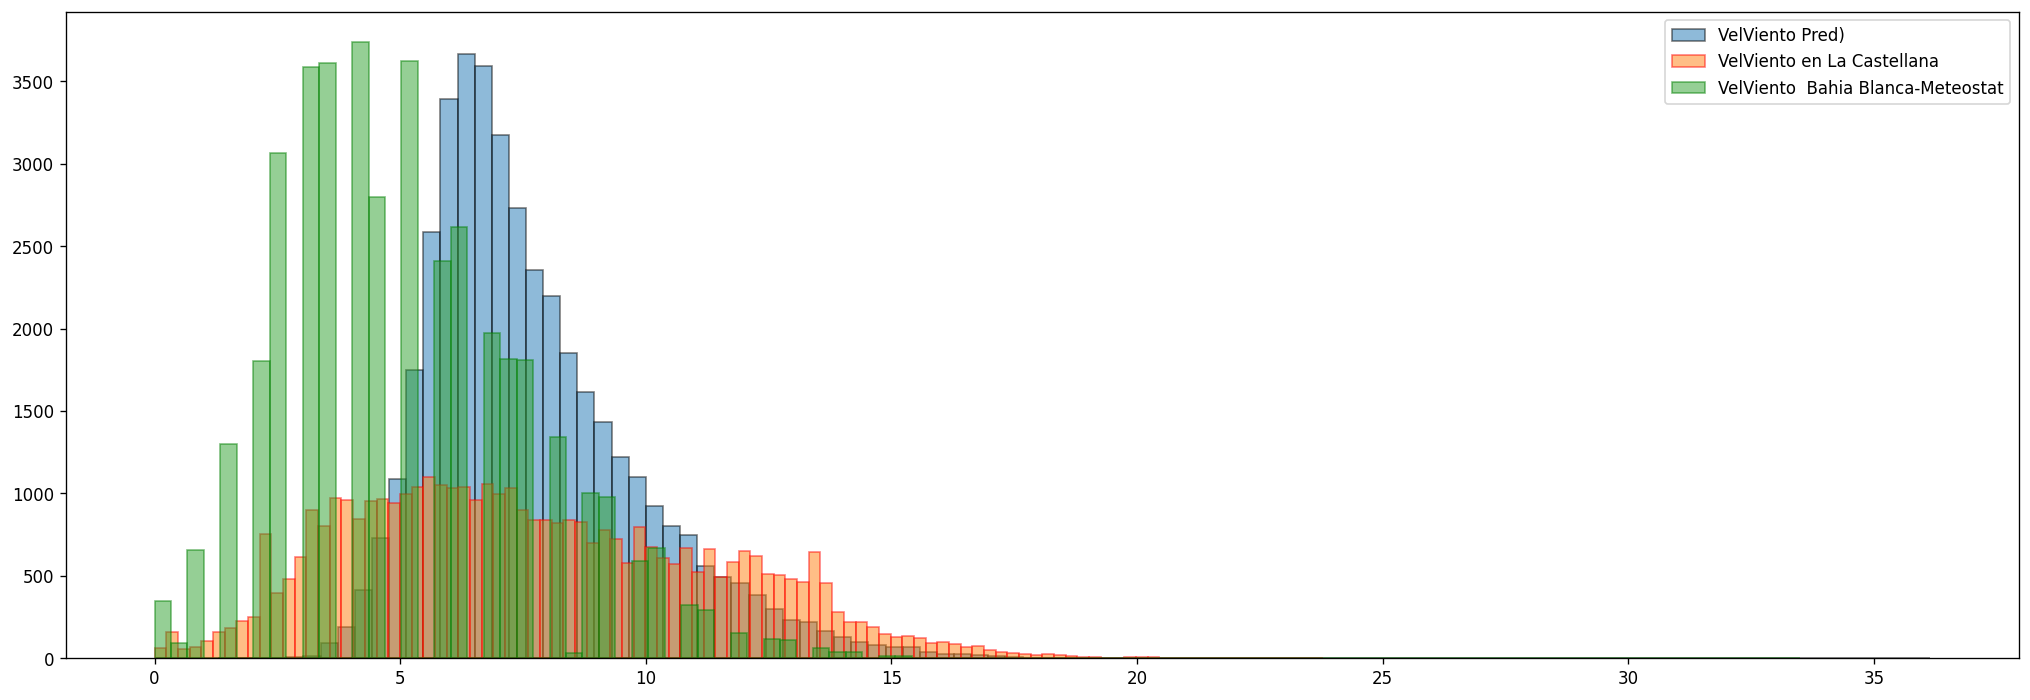

In [27]:

plt.hist(df['Vel_Viento_pred'], edgecolor='black', alpha=0.5, label='VelViento Pred)', bins=100)  # Solid line for Variable 1
plt.hist(df['VelViento'], edgecolor='red', alpha=0.5, label='VelViento en La Castellana', bins=100)  # Solid line for Variable 2
plt.hist(df['wspd_ms'], edgecolor='green', alpha=0.5, label='VelViento  Bahia Blanca-Meteostat', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

### Visualización de la Series de Tiempo

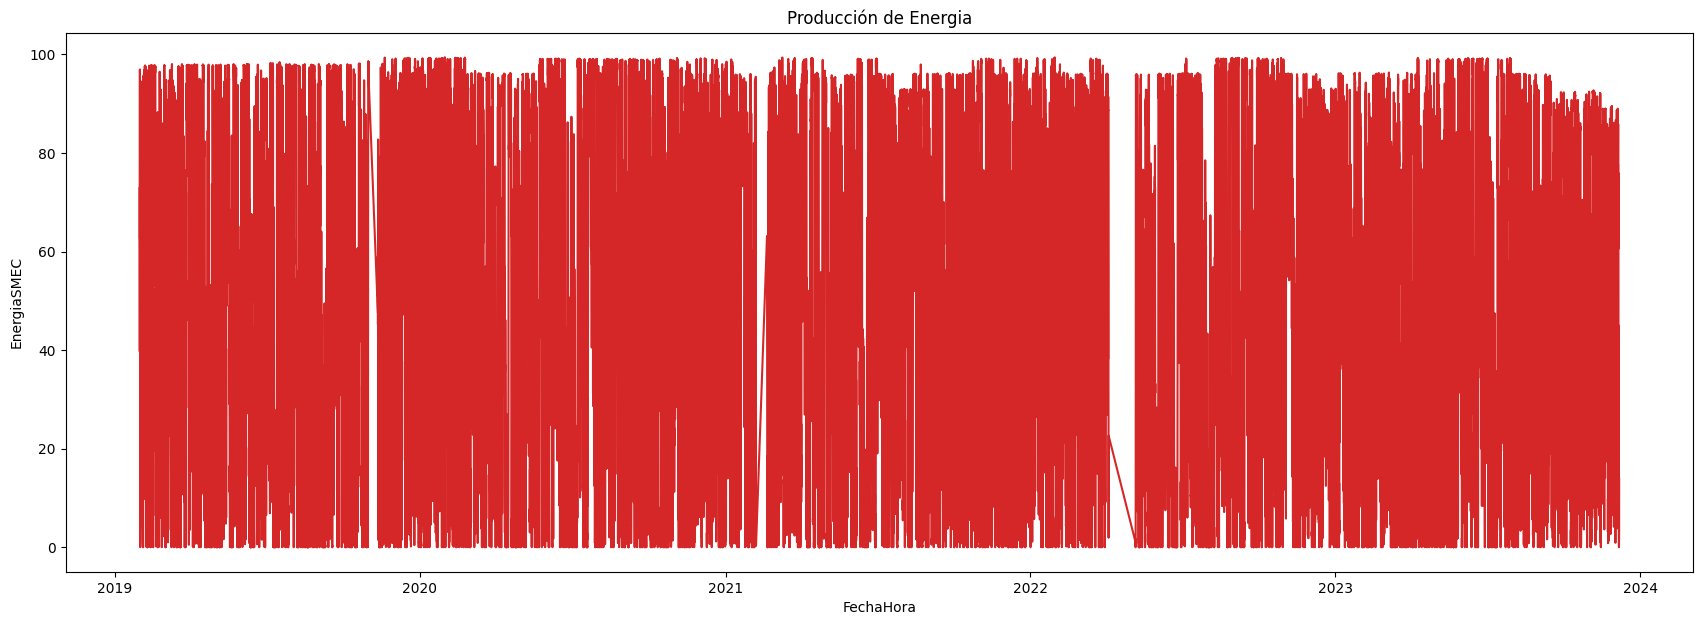

In [28]:
def plot_df(df, x, y, title="", xlabel='FechaHora', ylabel='EnergiaSMEC', dpi=100):
    plt.figure(figsize=(21,7), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df, x=df.FechaHora, y=df["EnergiaSMEC"], title='Producción de Energia')    

  
### Patrones estacionales
Como es una serie mensual y sigue un cierto patrón repetitivo cada año, se puede plotear cada uno de los mismos como una línea separada en un gráfico.

In [ ]:
# Preparacion de los datos.
df.reset_index(inplace=True)
df['year'] = [d.year for d in df.FechaHora]
df['month'] = [d.strftime('%b') for d in df.FechaHora]
years = df['year'].unique()


In [ ]:
df.head()

In [ ]:
# Preparacion de los colores.
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

In [ ]:
# Ploteo de las graficas.
plt.figure(figsize=(21,7), dpi=120)
for i, y in enumerate(years):
    if i > 0: 
         plt.plot('month', 'EnergiaSMEC', data=df.loc[df.year==y, :], color=mycolors[i], label=y)         
            #plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'EnergiaSMEC'][-1:].values[0], y, fontsize=12, color=mycolors[i]) 

            
            
# Ajustes finales a las graficas.
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Energy$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Energia Eolica Generada", fontsize=20)
plt.show()

Se observa que hay una caída en las ventas cada febrero y vuelve a subir en marzo, cayendo nuevamente en abril. Este patrón se repite cada año.  
Pero además, podemos observar que las ventas incrementan su volumen. Se puede visualizar esta tendencia y como varia cada año con boxplots, comparando mes a mes y año a año.

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(21,7), dpi=120)
#sns.boxplot(x='year', y='Exported_Energy_1H_kWh', data=df, ax=axes[0])
#sns.boxplot(x='month', y='Exported_Energy_1H_kWh', data=df.loc[~df.year.isin([2022, 2023]), :])
sns.boxplot(x='month', y='Exported_Energy_1H_kWh', data=df)

#axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Aqui podemos ver que los meses de enero y diciembre son en los que mayor ventas hay.
### Tendencia
Si tenemos una serie de tiempo con valores positivos crecientes y queremos visualizar su crecimiento podemos plotearla de forma simétrica con el eje X con el signo cambiado para aprovechar su área como recurso de visualización.

In [ ]:
# Dataset de pasajeros de aerolineas.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'])
x = df['date'].values
y1 = df['value'].values

fig, ax = plt.subplots(1, 1, figsize=(21,7), dpi=120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Air Passengers (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()

Volvemos a la presentación
## Análisis de series de tiempo
### Patrones en series de tiempo

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(21,7), dpi=120)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

plt.show()

Otro aspecto a considerar es el comportamiento cíclico, sucede cuando el patrón de subida y bajada no ocurre en un intervalo fijo basado en fechas del calendario.  
### Series aditivas y multiplicativas
Descomponiendo la serie temporal Drug Sales en sus componentes mediante el paquete `statsmodels`

In [ ]:
# Volvemos a cargar el dataset A10.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Decomposicion aditiva.
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Descomposicion multiplicativa.
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Graficamos.
plt.rcParams.update({'figure.figsize': (21,14)})
result_add.plot().suptitle('Additive Decompose', fontsize=20)
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
plt.show();

El parametro `extrapolate_trend='freq'` se encarga de los valores faltantes en la tendencia y los residuos al inicio de la serie.  
Si se observa atentamente los residuos de la descomposición aditiva, se puede observar un cierto patron restante no capturado por las otras componentes.  
La descomposición multiplicativa luce bastante aleatoria, lo cual es lo deseado en este tipo de descomposiciones.    
La salida numérica de tendencia, estacionalidad y componentes residuales son guardados en los objetos `result_mul` y `result_add` 

In [ ]:
# Extrayendo las componentes y guardandolas en un DataFrame: Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

El producto de `seas`, `trend` y `resid` deberia ser igual a `actual_values`  
Volvemos a la presentación.
### Series de tiempo estacionarias

In [ ]:
# Volvemos a cargar el dataset A10
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

### Ruido blanco
Al igual que una serie estacionaria, el ruido blanco no es una función del tiempo, es decir su media y varianza no cambian con el tiempo. Pero la diferencia es que el ruido blanco es completamente aleatorio con media de cero. En el ruido blanco no hay un patron subyacente.  

In [ ]:
# Generando ruido aleatorio.
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k', figsize=(21,7));

Volvemos a la presentación.
### Quitar la tendencia
Restando la linea de mejor ajuste

In [ ]:
# Dataset de Drug Sales.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
# Funcion `signal()` del paquete sciPy
detrended = signal.detrend(df.value.values)
plt.figure(figsize=(21,7), dpi=120)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16);

Usando `statmodels`  y substrayendo el componente `trend`

In [ ]:
# Dataset de Drug Sales.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Descomposicion multiplicativa.
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Se la restamos al nivel de base.
detrended = df.value.values - result_mul.trend
plt.figure(figsize=(21,7), dpi=120)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16);

Volvemos a la presentación.
### Quitar la estacionalidad

In [ ]:
# Dataset de Drug Sales.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Descomposicion multiplicativa.
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Dividimos por la componente estacional.
deseasonalized = df.value.values / result_mul.seasonal

# Graficamos.
plt.figure(figsize=(21,7), dpi=120)
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16);

Volvemos a la presentación
### Testear si una serie tiene estacionalidad

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})
# Graficamos la funcion de autocorrelacion para la serie de Drug Sales.
autocorrelation_plot(df.value.tolist());

En la serie mensual de Drug Sales hay patrones repetidos cada año con picos en las lineas 12, 24, 36, etc. De todas formas estos patrones no siempre son tan evidentes en datasets de la vida real.  
El Canova-Hansen Test es un test formal para determinar si es necesario quitar la estacionalidad de la serie mediante diferencia estacionaria.  
Volvemos a la presentación
### Valores faltantes
Introduzcamos valores faltantes en una serie conocida para medir la efectividad de cada una de ellas, luego mediremos el error cuadratico medio de los valores imputados contra los valores reales.

In [ ]:
# Importamos el dataset original y el que contiene datos faltantes.
df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date').head(100)
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10_missings.csv', parse_dates=['date'], index_col='date')

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(20, 15))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-");

Volvemos a la presentación.
## Autocorrelación
### Funciones de autocorrelación

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv',delimiter=';', header=0)

#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Calcula ACF y PACF hasta 50 lags.
acf_50 = acf(df.Exported_Energy_1H_kWh, nlags=50)
pacf_50 = pacf(df.Exported_Energy_1H_kWh, nlags=50)

# Graficamos las funciones.
fig, axes = plt.subplots(1,2,figsize=(21,7), dpi=120)
plot_acf(df.Exported_Energy_1H_kWh.tolist(), lags=50, ax=axes[0])
plot_pacf(df.Exported_Energy_1H_kWh.tolist(), lags=50, ax=axes[1]);

La autocorrelacion con el lag 0 siempre va a ser 1. Las bandas azules indican el nivel significancia, es decir si lo podemos distinguir significativamente del cero.  
Volvemos a la presentación.
### Ploteo de lags

In [ ]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


# Importamos el dataset A10 y uno de manchas solares.
ss = pd.read_csv('https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv',delimiter=';', header=0)
#a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Ploteamos los lags.
fig, axes = plt.subplots(1, 4, figsize=(21,7), sharex=True, sharey=True, dpi=120)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.Exported_Energy_1H_kWh, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Wind Energy \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

#fig, axes = plt.subplots(1, 4, figsize=(21,7), sharex=True, sharey=True, dpi=120)
#for i, ax in enumerate(axes.flatten()[:4]):
#    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
#    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

Volvemos a la presentación.
### Suavizado de una serie de tiempo

In [ ]:
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# Importamos un dataset de equipamiento electrico manufacturado en la eurozona.
#df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/elecequip.csv', parse_dates=['date'], index_col='date')


# Custom date parsing function for the "Date" column
def custom_date_parser(date_string):
    return pd.to_datetime(date_string, format='%d/%m/%Y %H:%M')

path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv'

# Read the CSV file with semicolon as delimiter, specifying the custom date parser
df_orig = pd.read_csv(path, parse_dates=['Date'], date_parser=custom_date_parser, delimiter=';', header=0,index_col='Date')


# 1. Medias moviles.
df_ma = df_orig.Exported_Energy_1H_kWh.rolling(3, center=True, closed='both').mean()

# 2. Loess smoothing (5% y 15%)
df_loess_5 = pd.DataFrame(lowess(df_orig.Exported_Energy_1H_kWh, np.arange(len(df_orig.Exported_Energy_1H_kWh)), frac=0.05)[:, 1], index=df_orig.index, columns=['Exported_Energy_1H_kWh'])
df_loess_15 = pd.DataFrame(lowess(df_orig.Exported_Energy_1H_kWh, np.arange(len(df_orig.Exported_Energy_1H_kWh)), frac=0.15)[:, 1], index=df_orig.index, columns=['Exported_Energy_1H_kWh'])

# Graficamos los tres tipos de suavizado.
fig, axes = plt.subplots(4,1, figsize=(21, 15), sharex=True, dpi=120)
df_orig['Exported_Energy_1H_kWh'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['Exported_Energy_1H_kWh'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['Exported_Energy_1H_kWh'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

Volvemos a la presentación.
## Pronóstico

In [ ]:
# Trabajemos con un dataset de trafico en un sitio web.
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/PEOlivos_01_05_2022_14_08_2023_Hourly.csv'

# Read the CSV file with semicolon as delimiter, specifying the custom date parser
df = pd.read_csv(path, delimiter=';', header=0)


result = adfuller(df.Exported_Energy_1H_kWh.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Como en este caso el p-value es mayor que el nivel de significancia, diferenciemos la serie

In [ ]:
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})

# Serie original.
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1era diferenciacion.
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2da diferenciacion.
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

En la serie de arriba, vemos que se hace estacionaria en dos ordenes de diferenciacion, pero se puede observar que en la segunda diferenciacion el lag entra en zona negativa rápidamente, lo que indica que se pudo haber sobrediferenciado. Por lo tanto, tomamos el orden anterior de 1, asi que tendremos una estacionalidad débil como nos indica el test.  
También podemos estimar el termino d con la funcion `ndiffs` del paquete `pmdarima`

In [ ]:
y = df.Exported_Energy_1H_kWh

## ADF Test
ndiffs(y, test='adf')  # 2

In [ ]:
# KPSS test
ndiffs(y, test='kpss')  # 0

In [ ]:
# PP test:
ndiffs(y, test='pp')  # 2

Volvemos a la presentación.
### Parámetro p de ARIMA

In [ ]:
# Grafico PACF de la primera diferenciacion de la serie nos da una pista de p.
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Exported_Energy_1H_kWh); axes[0].set_title('0 Differencing')
axes[1].set(ylim=(0,1.1))
plot_pacf(df.Exported_Energy_1H_kWh.dropna(),lags=50, ax=axes[1])

plt.show()

Podemos observar que el lag 1 de PACF es bastante significativo dado que está bien arriba de la linea de significancia.  
El lag 2 tambien es significativo cruzando la region azul del grafico.  
Por ahora establecemos p en 1  
### Parámetro q de ARIMA

In [ ]:
# Grafico ACF de la primera diferenciacion de la serie nos da una pista de q.
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Exported_Energy_1H_kWh); axes[0].set_title('0 Differencing')
axes[1].set(ylim=(0,1.1))
plot_acf(df.Exported_Energy_1H_kWh.dropna(), ax=axes[1])

plt.show()

Un par de lags van bien arriba de la linea de significancia, por lo tanto establezcamos `q = 2`  
Cuando haya dudas, usar siempre el modelo mas sencillo que explique Y.  
Volvemos a la presentación
### Entrenando un modelo ARIMA

In [ ]:
# 1,1,2 ARIMA Model
model = ARIMA(df.Exported_Energy_1H_kWh, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

El resumen del modelo revela mucha información. La tabla en el medio es la tabla de coeficientes donde la columna `coef` son los pesos de los respectivos términos. Vemos que el termino MA.2 es cercano a cero y el `P>|z|` está por encima del nivel de significancia, debería ser menor a 0.05 para la respectiva X para ser significativa. Por lo tanto podemos armar un nuevo modelo sin el termino MA.2

In [ ]:
# 1,1,1 ARIMA Model con q = 1
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

El AIC del modelo se redujo, lo cual es bueno, el p-value de AR.1 y MA.1 se ha mejorado y es altamente significativo (<<0.05).  
Podemos graficar los residuos para asegurarnos que no haya patrones (que media y varianza parezcan constantes).

In [ ]:
plt.rcParams.update({'figure.figsize':(21,7), 'figure.dpi':120})

# Graficamos los errores residuales.
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen tener media cercana a cero y varianza uniforme.  
Grafiquemos ahora los valores reales contra los entrenados usando `plot_predict()`

In [ ]:
# Real vs Entrenado
model_fit.plot_predict(dynamic=False)
plt.show()

Cuando establecemos `dynamic=false` los valores reales de los lags son usados para la prediccion.  
Esto quiere decir que el modelo se entrena hasta el valor previo conocido para hacer la siguiente prediccion. Esto puede hacer que el pronóstico y valor real luzcan artificialmente bien.  
Hasta aqui obtuvimos un modelo bastante decente pero ¿Es el mejor?  Debemos compararlo con otros modelos.  
Ahora pronostiquemos el futuro y comparemos contra la performance real.  
Volvemos a la presentación.
### Out-of-Time Cross validation

In [ ]:
# Creamos los sets de entrenamiento y test.
train = df.Exported_Energy_1H_kWh[:9336]
test = df.Exported_Energy_1H_kWh[9336:]

# Entrenamos el modelo
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit(disp=-1)  

# Pronosticamos.
fc, se, conf = fitted.forecast(1649, alpha=0.05)  # 95% conf

# Como una serie de Pandas.
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Graficamos.
plt.figure(figsize=(21,7), dpi=120)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Podemos ver que el modelo ARIMA(1,1,1) sigue la tendencia correctamente y los valores reales observados caen en la banda del 95% de confidence.  
Tambien se observa que los pronosticos están consistentemente abajo de los reales. Eso significa que agregando una pequeña constante a nuestro pronóstico, la precision va a mejorar, por lo tanto, hay espacio para mejora.  
Vamos a incrementar el orden de diferenciacion en 2, es decir, establecer `d=2` e iterativamente incrementar `p` hasta 5 y despues `q` hasta 5, para observar que modelo nos da el menor AIC. Vamos a generar también una gráfica que nos acerque los valores reales con los pronosticos.  
Debemos observar los p-values de los terminos AR y MA en el resumen del modelo, deberían ser cercanos a cero idealmente, o menores a 0.05.

In [ ]:
# Entrenamos el modelo.
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Pronosticamos.
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Como una serie de Pandas.
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Graficamos.
plt.figure(figsize=(21,7), dpi=120)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Vemos que el AIC se ha reducido a 440 desde 515 y los p-value de los terminos de X estan en menos de 0.05, ha habido una mejora.
Idealmente habría que volver atrás a múltiples puntos en el tiempo, por ejemplo 1, 2, 3 o 4 quarters para observar como los pronosticos están performando en varias partes del año.  
Volvemos a la presentación.
### Métricas de evaluación para pronósticos

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # Corr
    acf1 = acf(fc-test)[1]                      # ACF1
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # Min-Max

    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

Alrededor de un 2.2% de MAPE indica que el modelo es un 97.8% preciso a la hora de pronosticar las siguientes 15 observaciones.  
Volvemos a la presentación.
### Auto ARIMA

In [ ]:
# Dataset de trafico de sitio web
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Creamos los sets de entrenamiento y test.
# train = df.value[:85]
# test = df.value[85:]

# train
model = pm.auto_arima(df.Exported_Energy_1H_kWh, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

## Gráficos de residuos del modelo ARIMA

In [ ]:
model.plot_diagnostics(figsize=(20,15))
plt.show()

**Arriba izquierda** Los errores residuales parecen fluctuar alrededor de una media de cero y tener varianza uniforme.  
**Arriba derecha** El gráfico de densidad sugiere distribución normal con media cero.  
**Abajo a la izquierda** Todos los puntos deberían caer en línea con la linea roja. Cualquier desvío significativo implicaría que la distribución está sesgada.  
https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html  
**Abajo a la derecha** El correlograma, o gráfico ACF muestra que los errores residuales no están autocorrelacionados. Cualquier autocorrelación implicaría que hay algún patrón en los errores residuales que no están siendo explicados por el modelo, por lo tanto habría que revisar con más X (predictores) en el modelo.  
Hagamos un nuevo pronóstico:  

In [ ]:
# Pronóstico
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.Exported_Energy_1H_kWh), len(df.Exported_Energy_1H_kWh)+n_periods)

# Generamos una serie para graficar.
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Graficamos
plt.figure(figsize=(21,7), dpi=120)
plt.plot(df.Exported_Energy_1H_kWh)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()